I will use:
1. Open source classes
2. In house package classes (done by me)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving pipeline
import joblib

# from Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (AddMissingIndicator,MeanMedianImputer,CategoricalImputer,)

from feature_engine.encoding import (RareLabelEncoder,OrdinalEncoder)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

#import pre_process as pp
import preprocess_ as pp

In [23]:
data = pd.read_csv('train.csv')
print(data.shape)

# visualise the dataset
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [24]:
data['MSSubClass'] = data['MSSubClass'].astype('O')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], 
                                                              axis=1),data['SalePrice'],
                                                    test_size=0.1,random_state=108)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

In [26]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [27]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure','BsmtFinType1', 
                                     'GarageFinish']
CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']

# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"

# this variable is to calculate temporal variable,can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]

# variables to binarize
BINARIZE_VARS = ['ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual','HeatingQC', 'KitchenQual', 'FireplaceQu']
EXPOSURE_VARS = ['BsmtExposure']
FINISH_VARS = ['BsmtFinType1']
GARAGE_VARS = ['GarageFinish']
FENCE_VARS = ['Fence']

# categorical variables to encode
CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour','LotConfig', 
                    'Neighborhood', 'RoofStyle', 'Exterior1st','Foundation', 'CentralAir', 
                    'Functional', 'PavedDrive','SaleCondition']

# variable mappings
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}
EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,'LwQ': 2, 'Rec': 3, 'BLQ': 4, 
                   'ALQ': 5, 'GLQ': 6}
GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

In [28]:
#selected required FEATURES only
FEATURES = ['MSSubClass','MSZoning','LotFrontage','LotShape','LandContour','LotConfig',
            'Neighborhood','OverallQual','OverallCond','YearRemodAdd','RoofStyle',
            'Exterior1st','ExterQual','Foundation','BsmtQual','BsmtExposure','BsmtFinType1',
            'HeatingQC','CentralAir','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath',
            'HalfBath','KitchenQual','TotRmsAbvGrd','Functional','Fireplaces','FireplaceQu',
            'GarageFinish','GarageCars','GarageArea','PavedDrive','WoodDeckSF','ScreenPorch',
            'SaleCondition',"YrSold",]

#reducing original dataset into only selected features
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 37), (146, 37))

# Pipeline - End-to-end

Now I have 3 steps less, they are commented out. So pipeline is also simpler:

1. yeo-johnson transformation
2. 1 of the mappings
3. selection procedure

this makes pipeline faster and easier to deploy

In [29]:
price_pipeline = Pipeline([
    ### --- Imputation ---
    ## - Categorical variable with string missing -
    ('missing_imputation',
     CategoricalImputer(imputation_method='missing',
                        variables=CATEGORICAL_VARS_WITH_NA_MISSING)),
    ('frequent_imputation',
     CategoricalImputer(imputation_method='frequent', 
                        variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),
    #adding missing indicator
    ('missing_indicator', 
     AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
    ## - impute numerica variables with mean -
    ('mean_imputation', 
     MeanMedianImputer(imputation_method='mean', 
                       variables=NUMERICAL_VARS_WITH_NA)),
    
    ### --- Temporal Variables ---
    ('elapsed_time', 
     pp.TemporalVariableTransformer(variables=TEMPORAL_VARS, 
                                    reference_variable=REF_VAR)),
    ('drop_features', 
     DropFeatures(features_to_drop=[REF_VAR])),
    
    ### --- Transformation ---
    ('log', 
     LogTransformer(variables=NUMERICALS_LOG_VARS)),
    ('binarizer', 
     SklearnTransformerWrapper(transformer=Binarizer(threshold=0),
                               variables=BINARIZE_VARS)),
    
    ### --- Mappers ---
    ('mapper_qual', 
     pp.Mapper(variables=QUAL_VARS, 
               mappings=QUAL_MAPPINGS)),
    ('mapper_exposure', 
     pp.Mapper(variables=EXPOSURE_VARS, 
               mappings=EXPOSURE_MAPPINGS)),
    ('mapper_finish', 
     pp.Mapper(variables=FINISH_VARS, 
               mappings=FINISH_MAPPINGS)),
    ('mapper_garage', 
     pp.Mapper(variables=GARAGE_VARS, 
               mappings=GARAGE_MAPPINGS)),
    ('rare_label_encoder', 
     RareLabelEncoder(tol=0.01, n_categories=1, 
                      variables=CATEGORICAL_VARS)),
    
    ### --- Categorical Encoding ---
    ('categorical_encoder', 
     OrdinalEncoder(encoding_method='ordered', 
                    variables=CATEGORICAL_VARS)),
    ('scaler', MinMaxScaler()),
    ('Lasso', Lasso(alpha=0.001,random_state=0))
])

In [30]:
#train pipeline
price_pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour',

# Evaluating model

In [33]:
#predictions for train set
pred = price_pipeline.predict(X_train)

#determining mse, rmse and r2
print('train mse: {}'.format(int(mse(np.exp(y_train),np.exp(pred)))))
print('train rmse: {}'.format(int(mse(np.exp(y_train),np.exp(pred),squared=False))))
print('train r2: {}'.format(r2_score(np.exp(y_train),np.exp(pred))))
print()

train mse: 796713845
train rmse: 28226
train r2: 0.8741364142168565



In [34]:
#predictions for test set
pred = price_pipeline.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(mse(np.exp(y_test),np.exp(pred)))))
print('test rmse: {}'.format(int(mse(np.exp(y_test),np.exp(pred),squared=False))))
print('test r2: {}'.format(r2_score(np.exp(y_test),np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

test mse: 951637794
test rmse: 30848
test r2: 0.843899320934139

Average house price:  163945


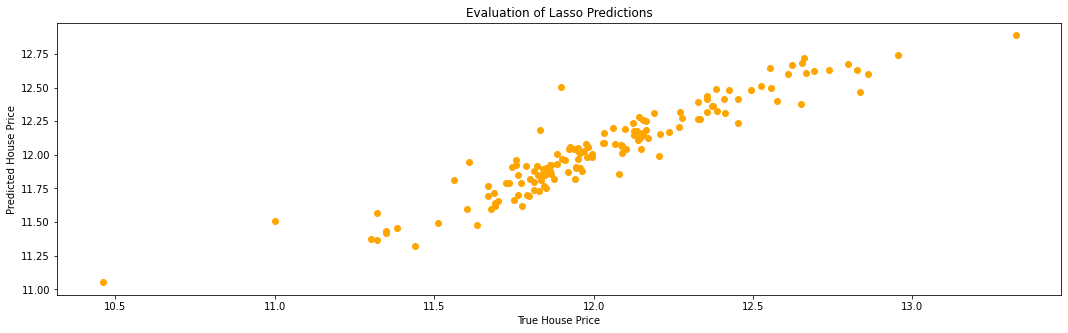

In [40]:
#evaluate predictions respect to real sale price
plt.figure(figsize=(18,5))

plt.scatter(y_test, price_pipeline.predict(X_test),color='orange')
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')
plt.show()

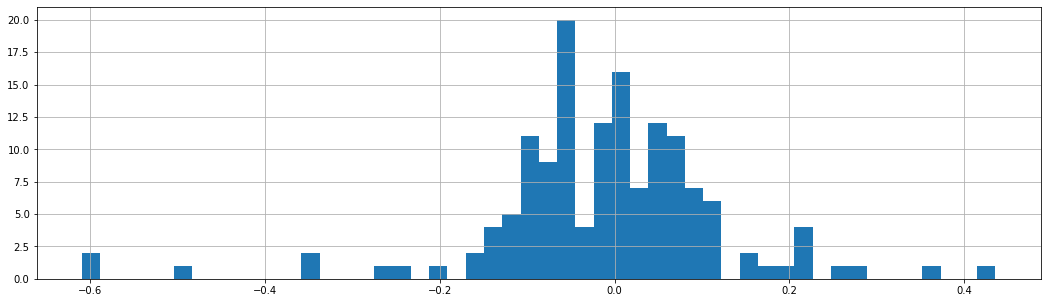

In [42]:
#distribution of the errors: must be fairly normally distributed
plt.figure(figsize=(18,5))

y_test.reset_index(drop=True,inplace=True)
preds = pd.Series(price_pipeline.predict(X_test))
errors = y_test - preds
errors.hist(bins=50)
plt.show()

In [44]:
#saving scaler/pipeline in pickle object

joblib.dump(price_pipeline, 'price_pipe.joblib') 

['price_pipe.joblib']

## Score on new/unseen data

In [51]:
new_data = pd.read_csv('test.csv')
new_data.drop('Id',axis=1,inplace=True)

new_data['MSSubClass'] = new_data['MSSubClass'].astype('O')

new_data = new_data[FEATURES]

print(new_data.shape)

(1459, 37)


In [52]:
##-- new variables with nan/missing values in them 
new_vars_with_na = [var for var in FEATURES if var not in 
                    CATEGORICAL_VARS_WITH_NA_FREQUENT+CATEGORICAL_VARS_WITH_NA_MISSING+
                    NUMERICAL_VARS_WITH_NA and new_data[var].isnull().sum() > 0]

new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

In [55]:
new_data[new_vars_with_na].tail()

,MSZoning,Exterior1st,BsmtFullBath,KitchenQual,Functional,GarageCars,GarageArea
1454,RM,CemntBd,0.0,TA,Typ,0.0,0.0
1455,RM,CemntBd,0.0,TA,Typ,1.0,286.0
1456,RL,VinylSd,1.0,TA,Typ,2.0,576.0
1457,RL,HdBoard,0.0,TA,Typ,0.0,0.0
1458,RL,HdBoard,0.0,TA,Typ,3.0,650.0


In [56]:
new_data[new_vars_with_na].isnull().mean()

MSZoning        0.002742
Exterior1st     0.000685
BsmtFullBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

**`Observation:`**
Very few nan values in test/unseen/new dataset which can be droped

In [58]:
new_data.dropna(subset=new_vars_with_na, inplace=True)

print(new_data.shape)

(1449, 37)


Only 10 data points are drope which is not a big loss

In [62]:
new_preds = price_pipeline.predict(new_data)

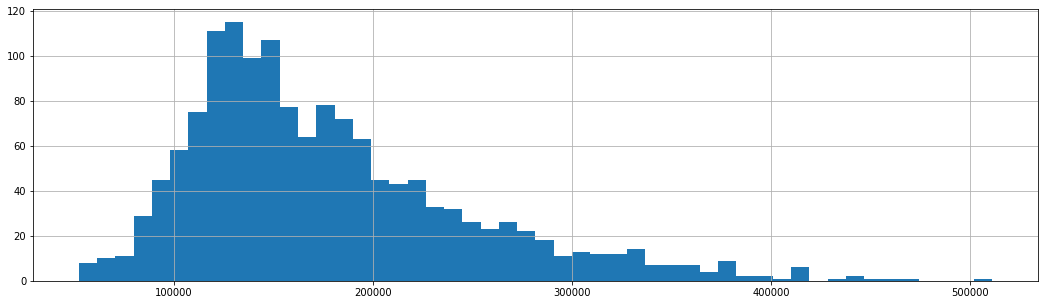

In [65]:
plt.figure(figsize=(18,5))

pd.Series(np.exp(new_preds)).hist(bins=50)
plt.show()

**`NOTE:`**

I will have to give special atention to variables which have nan values in `new_data` but dont have any nan values in training data
* I will also have to write some code to handle this issue

`Variables which will require speciall atention are given bellow`

In [66]:
new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']